In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

#To ensure you have only the correct device visible:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('Datasets/mergedChEMBLDF.csv')
df = data[data.columns.drop(list(data.filter(regex='operator')))]

/ihome/gidakwo/anaconda3/envs/ml_env/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7,29,31,33,35,37,39) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head()

,stdInChiKey,1613933_value,1614063_value,1614364_value,1614421_value,1794557_value,1909116_value,1909123_value,1909130_value,1909184_value,...,1909195_value,1909196_value,2218781_value,2328568_value,3705123_value,3705362_value,3705488_value,3706373_value,smiles,smiles_parent
0,RJYFVJPEXKPGNZ-UHFFFAOYSA-N,NaN,NaN,NaN,1412.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COc1ccccc1C2CCN(CC2)C(=Nc3ccc(Br)cc3)S,COc1ccccc1C1CCN(C(S)=Nc2ccc(Br)cc2)CC1
1,GNWGGHKGEXNNMK-UHFFFAOYSA-N,NaN,NaN,NaN,17782.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cc1ccc(O)c(NC(=O)c2onc(c2)c3ccc(F)cc3)c1,Cc1ccc(O)c(NC(=O)c2cc(-c3ccc(F)cc3)no2)c1
2,LVDHDRPSCLIFHH-RDRPBHBLSA-N,NaN,NaN,5011.9,10000.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COc1ccccc1NC(=O)C(=O)N\N=C(/C)\CC(=O)Nc2ccc(OC...,COc1ccccc1NC(=O)C(=O)NN=C(C)CC(=O)Nc1ccc(OCc2c...
3,OJENVBWGZAMKEC-UHFFFAOYSA-N,NaN,NaN,NaN,707.9,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CC(=O)c1ccc(NC(=O)c2oc(cc2)c3ccc(Cl)cc3)cc1,CC(=O)c1ccc(NC(=O)c2ccc(-c3ccc(Cl)cc3)o2)cc1
4,HGUWAIXVEMNODZ-UHFFFAOYSA-N,NaN,NaN,NaN,19952.6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cc1nc2ncnn2c(N3CCN(CC3)c4cccc(c4)C(F)(F)F)c1C,Cc1nc2ncnn2c(N2CCN(c3cccc(C(F)(F)F)c3)CC2)c1C


In [26]:
df.shape

(65382, 23)

In [10]:
X = df['smiles_parent']
y = df.drop(['smiles_parent', 'stdInChiKey', 'smiles'], axis=1)
y.replace(to_replace = 'Unspecified', value = np.nan, inplace = True)

In [12]:
X_train,  X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#from sklearn.preprocessing import RobustScaler
#rbs = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(5.0, 95.0), copy=True)
#y_train = rbs.fit_transform((y_train))
#y_test = rbs.transform(y_test)

In [13]:
import keras.backend as K
from SmilesEnumerator import SmilesIterator
from SmilesEnumerator import SmilesEnumerator
sme = SmilesEnumerator()
#The SmilesEnumerator must be fit to the entire dataset, so that all chars are registered
sme.fit(X, extra_chars="56790%", extra_pad=10)
sme.leftpad = True

batch_size = 64
#The dtype is set for the K.floatx(), which is the numerical type configured for Tensorflow or Theano
generator = SmilesIterator(X_train, y_train, sme, batch_size = batch_size, dtype=K.floatx())
val_generator = SmilesIterator(X_test, y_test, sme, batch_size = batch_size, dtype=K.floatx())

X_,y_ = generator.next()

Using TensorFlow backend.


In [15]:
print(X_.shape)
print(y_.shape)
#--------------------------------------------------------
input_shape = X_.shape[1:]
output_shape = y_.shape[1]

(64, 250, 39)
(64, 20)


In [27]:
def r2_nan(y_true, y_pred):
    from keras import backend as K
    masked_true = tf.where(tf.is_nan(y_true), tf.zeros_like(y_true), y_true)
    masked_pred = tf.where(tf.is_nan(y_true), tf.zeros_like(y_true), y_pred)
    SS_res =  K.sum(K.square( masked_true-masked_pred ))
    SS_tot = K.sum(K.square( masked_true - K.mean(masked_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

import tensorflow as tf
from keras import backend as K
def mse_nan(y_true, y_pred):
    masked_true = tf.where(tf.is_nan(y_true), tf.zeros_like(y_true), y_true)
    masked_pred = tf.where(tf.is_nan(y_true), tf.zeros_like(y_true), y_pred)
    return K.mean(K.square(masked_pred - masked_true), axis=-1)


#Build a SMILES based RNN QSAR model with Keras.
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.core import Dropout
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers
from keras.optimizers import RMSprop, Adam

model = Sequential()
model.add(LSTM(64, input_shape=input_shape, return_sequences=False #dropout = 0.19, unroll= True 
              ))

#model.add(LSTM(16, dropout = 0.1, return_sequences=False)) 
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(output_shape))
                #kernel_regularizer=regularizers.l1_l2(0.005,0.01),
                #activation="linear"))

model.compile(loss=mse_nan, optimizer=RMSprop(lr=0.005), metrics=[r2_nan])
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,patience=50, min_lr=0.00001, verbose=1)



In [31]:
history = model.fit_generator(generator, validation_data = val_generator, validation_steps=len(X_test)/batch_size,
                              steps_per_epoch=len(X_train)/batch_size, 
                              epochs=100, verbose = 1,
                              callbacks=[reduce_lr])

Epoch 1/100
767/766 [==============================] - 231s 301ms/step - loss: 12761478.5027 - r2_nan: 0.6421 - val_loss: 11985433.5358 - val_r2_nan: 0.6671
Epoch 2/100
767/766 [==============================] - 234s 305ms/step - loss: 12706737.0595 - r2_nan: 0.6433 - val_loss: 11979091.7097 - val_r2_nan: 0.6671
Epoch 3/100
767/766 [==============================] - 232s 302ms/step - loss: 12683127.4320 - r2_nan: 0.6437 - val_loss: 11980172.5149 - val_r2_nan: 0.6671
Epoch 4/100
767/766 [==============================] - 230s 299ms/step - loss: 12695002.2558 - r2_nan: 0.6436 - val_loss: 11978709.5106 - val_r2_nan: 0.6671
Epoch 5/100
767/766 [==============================] - 230s 300ms/step - loss: 12725687.0912 - r2_nan: 0.6427 - val_loss: 11980268.4337 - val_r2_nan: 0.6671
Epoch 6/100
767/766 [==============================] - 233s 304ms/step - loss: 12688131.6703 - r2_nan: 0.6439 - val_loss: 11983751.0100 - val_r2_nan: 0.6670
Epoch 7/100
767/766 [==============================] - 231

Epoch 53/100
767/766 [==============================] - 231s 301ms/step - loss: 12745724.5826 - r2_nan: 0.6421 - val_loss: 11987361.1755 - val_r2_nan: 0.6670
Epoch 54/100
767/766 [==============================] - 232s 303ms/step - loss: 12724827.5550 - r2_nan: 0.6425 - val_loss: 11983109.3477 - val_r2_nan: 0.6671
Epoch 55/100
767/766 [==============================] - 230s 300ms/step - loss: 12741719.6557 - r2_nan: 0.6425 - val_loss: 11975892.6510 - val_r2_nan: 0.6672
Epoch 56/100
767/766 [==============================] - 231s 302ms/step - loss: 12747170.3618 - r2_nan: 0.6422 - val_loss: 11984510.5587 - val_r2_nan: 0.6671
Epoch 57/100
767/766 [==============================] - 230s 299ms/step - loss: 12709489.4742 - r2_nan: 0.6430 - val_loss: 11979786.9009 - val_r2_nan: 0.6671
Epoch 58/100
767/766 [==============================] - 231s 302ms/step - loss: 12693900.9363 - r2_nan: 0.6440 - val_loss: 11977986.0728 - val_r2_nan: 0.6671
Epoch 59/100
767/766 [==============================

In [32]:
scores = model.evaluate_generator(val_generator, steps=len(X_test)/batch_size)

print ('mse={}, r2_score={}'.format(*scores))
print(history.history.keys())

mse=11976339.373302337, r2_score=0.6670885356187558
dict_keys(['val_r2_nan', 'r2_nan', 'val_loss', 'lr', 'loss'])


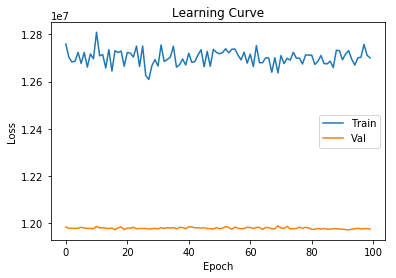

In [33]:
plt.figure()
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Val")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Learning Curve")
plt.legend()
#plt.savefig("Images/%s_learning.png"%(assay))
plt.show()